# Training an Autoencoder with FishLeg versus ADAM

FishLeg is a second-order optimizer for training neural networks. This means FishLeg uses second-order information - or the curvature of weight-space - to make more optimal adjustments to weights during neural network training. This allows FishLeg to reach lower losses with fewer epochs. This notebook demonstrates using FishLeg to train a basic autoencoder, working with the MNIST dataset of handwritten digits, and compares the training performance with ADAM, a popular first-order neural network optimizer.

FishLeg was first introduced by [Garcia et. al.](https://openreview.net/forum?id=c9lAOPvQHS) at ICLR 2023. Please see the official [GitHub page](https://github.com/mtkresearch/FishLeg) for more examples, explanations and for citing FishLeg.

### Imports and notebook preparation

In [1]:
# Imports

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm # tqdm ('te quiero demasiado') creates progress bars for loops
import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from data_utils import read_data_sets # Accessing examples/data_utils.py
import copy
from torch.utils.data.dataloader import default_collate


torch.set_default_dtype(torch.float32) # Set the precision of torch tensors to 32 bit floats

sys.path.append("../src")

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Select the GPU to use, in this case there is only 1, so the first one

seed = 13
torch.manual_seed(seed) # Specify the seed for generating random numbers, for reproducibility of results:
torch.backends.cudnn.benchmark = False # ??
torch.backends.cudnn.deterministic = True # Allowing reproducibility of results if we are using CUDA

### GPU Acceleration
Depending on your system, PyTorch can use one of several hardware accelerations for training. For efficiency, we will select the most powerful device.

In [2]:
if torch.cuda.is_available(): # i.e. for NVIDIA GPUs
    device_type = "cuda"
elif torch.backends.mps.is_available(): # i.e. for Apple Silicon GPUs
    device_type = "mps"
else:
    device_type = "cpu"
    
device = torch.device(device_type) # Select best available device
print(f'Running on device: {device}')

Running on device: cuda


### Import the MNIST Dataset

MNIST is a famous dataset which contains examples of handwritten digits. The dataset consists of 60,0000 training images and 10,000 test images. More can information can be found in the MNIST [homepage](http://yann.lecun.com/exdb/mnist/).

The dataset is split into train and test datasets. We then prepare test, train and auxiliary dataloaders, which are iterator objects that allow for passing shuffled and batched data into PyTorch. **The auxiliary dataloader loads the same training data, however shuffled differently, and it is used in a meta-learning approach during the FishLeg optimisation. This additional dataloader is an important requirement for training with FishLeg.**

In [3]:
# We access MNIST using the data_utils.py function read_data_sets. This prepares the dataset for use in this example notebook in a concise manner.
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=True)
train_dataset = dataset.train # Accessing the training dataset
test_dataset = dataset.test # Accessing the test dataset

batch_size = 100 # Setting the batch size

# Creating the dataloader for the training data
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Creating the dataloader for the auxiliary data
aux_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
)

# Creating the dataloader for the test data
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False,
)

Begin loading data for MNIST
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


Lets look at the data inside the MNIST dataset by plotting a few of the images that will be used to test the trained model.

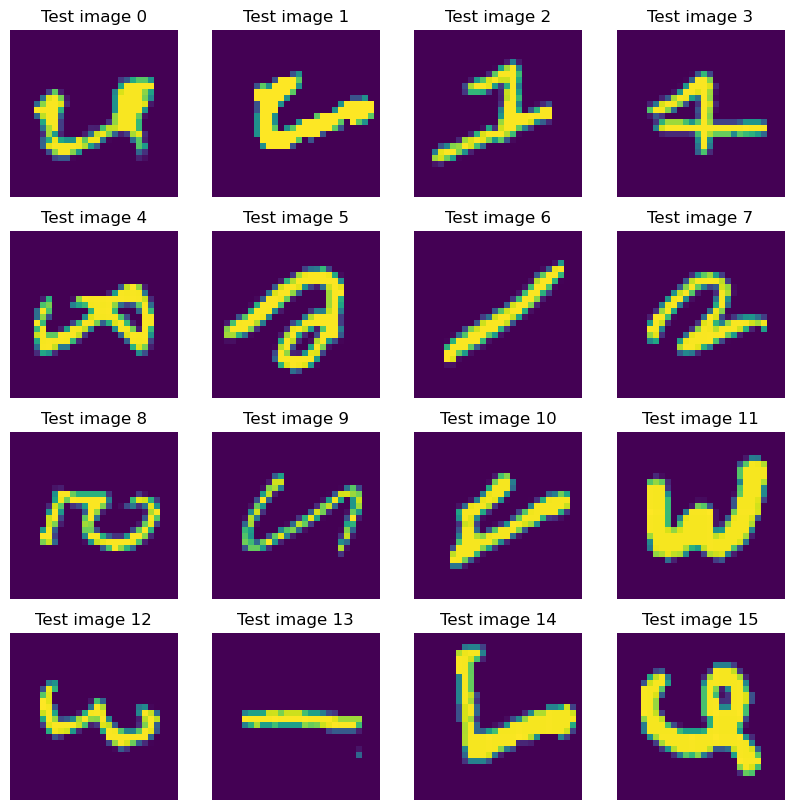

In [4]:
fig, axs = plt.subplots(4,4, figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.array(test_dataset[i])[0].reshape(28,28))
    ax.axis('off')
    ax.set_title(f"Test image {i}")

## Create autoencoder model

Here we create our autoencoder, `model`. We then initialise two copies of the model, one to be trained with the FishLeg optimizer and the other to be trained with ADAM, for comparison.

The architecture of the simple autoencoder model is as follows:
| Code | Explanation |
| :- | :- |
| `nn.Linear(784, 1000, dtype=torch.float32)`             | Input layer: Takes in a flattened 28x28 pixel (784 values) image as input and outputs a 1000-dimensional vector |
| `nn.ReLU()`                                             | Activation function: Applies the ReLU (Rectified Linear Unit) function to introduce non-linearity |
|`nn.Linear(1000, 500, dtype=torch.float32)`            | Hidden layer: Takes the 1000-dimensional vector and outputs a 500-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(500, 250, dtype=torch.float32)`          |    Hidden layer: Takes the 500-dimensional vector and reduces the output down to a 250-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(250, 30, dtype=torch.float32)`            |   Waist layer: Takes the 250-dimensional vector and outputs a 30-dimensional vector. This is the smallest compressed representation of the data, every possible feature should be able to be described with no less than 30 degrees of freedom. |
| `nn.Linear(30, 250, dtype=torch.float32)`     |          Start of the decoder part of the network: Takes the 30-dimensional vector and upscales to a 250-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(250, 500, dtype=torch.float32)`       |       Hidden layer: Takes the 250-dimensional vector and upscales again to a 500-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(500, 1000, dtype=torch.float32)`     |        Hidden layer: Takes the 500-dimensional vector and outputs a 1000-dimensional vector |
| `nn.ReLU()` | |
| `nn.Linear(1000, 784, dtype=torch.float32)`      |       Output layer: Takes the 1000-dimensional vector and outputs the 784-dimensional vector, which is the same size as the input. This is the reconstructed image. |


In [5]:
model = nn.Sequential(
    nn.Linear(784, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 30, dtype=torch.float32),
    nn.Linear(30, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 784, dtype=torch.float32),
)

## Initialising FishLeg optimizer

In [6]:
from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel
# Define the FishLeg model
# For compatibility with FishLeg, our model layers need to be initialised with additional parameters. This is completed by initialise_FishModel():
scale_factor = 1
damping = 0.1
# Specify the hardware device that will be used to train the model
model_FishLeg = copy.deepcopy(model).to(device)
model_FishLeg = initialise_FishModel(
    model_FishLeg, module_names="__ALL__", fish_scale=scale_factor / damping
)
model_FishLeg = model_FishLeg.to(device)
# Setting FishLeg optimizer parameters:
eta_adam = 1e-4
lr = 0.005
beta = 0.9
weight_decay = 1e-5
aux_lr = 1e-4
aux_eps = 1e-8
update_aux_every = 10
initialization = "normal"
normalization = True
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)
writer = SummaryWriter(
    log_dir=f"runs/MNIST_fishleg/lr={lr}_auxlr={aux_lr}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)
# Initialising FishLeg:
opt = FishLeg(
    model_FishLeg,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
)

## Training with FishLeg:

This training loop is identical to training with ADAM

In [7]:
epochs = 5

st = time.time()
eval_time = 0

train_losses_FishLeg = []
test_losses_FishLeg = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_FishLeg(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model_FishLeg.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_FishLeg(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_FishLeg.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_FishLeg.append(running_loss / n)
        test_losses_FishLeg.append(running_test_loss)

        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

Epoch 5: 100%|██████████| 600/600 [00:18<00:00, 33.13batch/s, loss=68.9, test_loss=75.7]


## Initialising ADAM optimizer:

In [8]:
# Define the control ADAM model
model_ADAM = copy.deepcopy(model).to(device)

lr = 0.005
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8
likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

opt = optim.Adam(
    model_ADAM.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)

writer = SummaryWriter(
    log_dir=f"runs/MNIST_adam/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

## Training with ADAM:

This training loop is identical to training with FishLeg

In [9]:
epochs = 5

st = time.time()
eval_time = 0

train_losses_ADAM = []
test_losses_ADAM = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_ADAM(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model_ADAM.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_ADAM(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model_ADAM.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )

        train_losses_ADAM.append(running_loss / n)
        test_losses_ADAM.append(running_test_loss)
        
        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

Epoch 5: 100%|██████████| 600/600 [00:06<00:00, 92.79batch/s, loss=92.8, test_loss=101] 


## FishLeg versus ADAM:

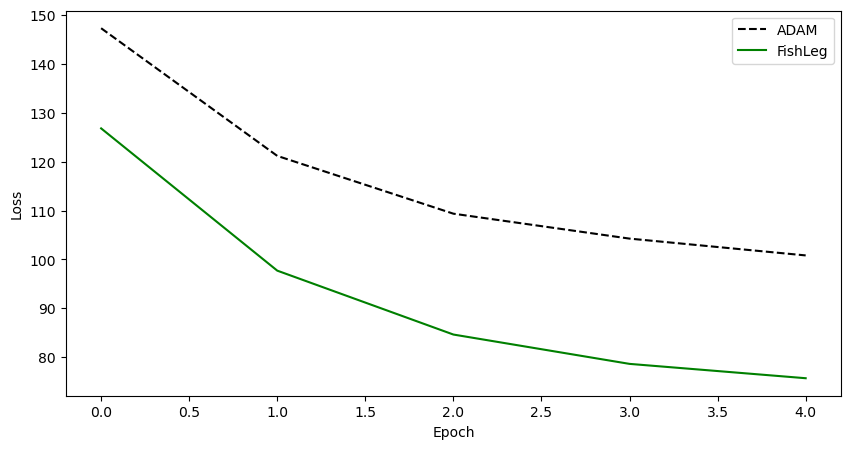

In [11]:
plt.figure(figsize=(10, 5))

plt.plot(test_losses_ADAM, 'k--',label="ADAM")
plt.plot(test_losses_FishLeg, 'g',label="FishLeg")

plt.xlabel("Epoch")
plt.ylabel("Loss") 

plt.legend()
plt.show()

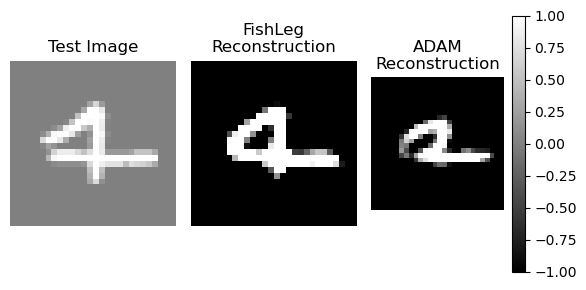

In [69]:
i=3
vmin = -1#np.min(np.array(test_dataset[i])[0])
vmax = 1#np.max(np.array(test_dataset[i])[0])
cmap = 'gray'

fig, axs = plt.subplots(1,3, figsize=(6,3))
axs=axs.flatten()

test_img = np.array(test_dataset[i])[0]
axs[0].imshow(test_img.reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].axis('off')
axs[0].set_title(f"Test Image")

fishleg_reconstruction = model_FishLeg(test_dataset[i][0].to(device)).cpu().detach().numpy()
axs[1].imshow(np.array(fishleg_reconstruction).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].axis('off')
axs[1].set_title(f"FishLeg\nReconstruction")

adam_reconstruction = model_ADAM(test_dataset[i][0].to(device)).cpu().detach().numpy()
pl = axs[2].imshow(np.array(adam_reconstruction).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].axis('off')
axs[2].set_title(f"ADAM\nReconstruction")

fig.colorbar(pl)
plt.tight_layout()

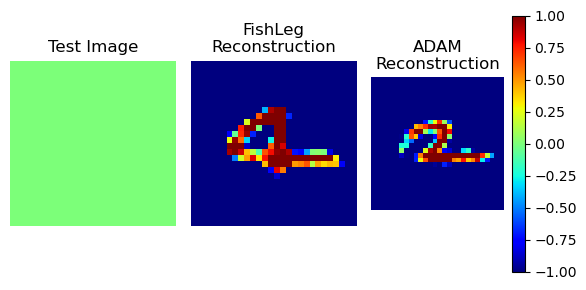

In [70]:
i=3
vmin = -1
vmax = 1
cmap = 'jet'

fig, axs = plt.subplots(1,3, figsize=(6,3))
axs=axs.flatten()

test_img = np.array(test_dataset[i])[0]
axs[0].imshow((test_img-test_img).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].axis('off')
axs[0].set_title(f"Test Image")

fishleg_reconstruction = model_FishLeg(test_dataset[i][0].to(device)).cpu().detach().numpy()
axs[1].imshow(np.array(fishleg_reconstruction-test_img).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].axis('off')
axs[1].set_title(f"FishLeg\nReconstruction")

adam_reconstruction = model_ADAM(test_dataset[i][0].to(device)).cpu().detach().numpy()
pl=axs[2].imshow(np.array(adam_reconstruction-test_img).reshape(28,28), cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].axis('off')
axs[2].set_title(f"ADAM\nReconstruction")

fig.colorbar(pl)
plt.tight_layout()